In [1]:
# This is Promptify

# Imports and Setup

import json
import subprocess
import time
import random
from dataclasses import dataclass, asdict
from typing import List, Dict, Tuple, Optional
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# Configuration

@dataclass
class Config:
    model_name: str = "llama3:latest"
    max_tokens: int = 32
    population_size: int = 16
    num_generations: int = 12
    elite_ratio: float = 0.25
    mutation_rate: float = 0.7
    crossover_rate: float = 0.2
    max_prompt_length: int = 15  
    seeds_file: str = "seeds.json"
    output_dir: str = "promptify_results"
    def __post_init__(self):
        Path(self.output_dir).mkdir(exist_ok=True)
config = Config()

In [3]:
# Task Definitions

@dataclass
class Task:
    input_text: str
    expected_output: str
    task_type: str = "factual_qa"    
    def evaluate(self, generated: str) -> Dict[str, float]:
        scores = {}        
        gen_lower = generated.lower().strip()
        exp_lower = self.expected_output.lower().strip()
        scores['correctness'] = 1.0 if exp_lower in gen_lower else 0.0        
        length_ratio = len(generated) / max(len(self.expected_output), 10)
        deviation = abs(length_ratio - 1.0)
        scores['brevity'] = max(0.0, min(1.0, 1.0 - deviation * 0.3))        
        fillers = ['certainly', 'of course', 'let me', 'i think', 'here is', 'the answer is']
        filler_count = sum(1 for f in fillers if f in gen_lower)
        scores['directness'] = max(0.0, min(1.0, 1.0 - filler_count * 0.15))        
        scores['constraint'] = 1.0 if len(generated.split()) <= 50 else 0.5
        return scores
TASK_SUITE = [
    Task("What is the capital of France?", "Paris"),
    Task("What is 15 + 27?", "42"),
    Task("Who wrote '1984'?", "George Orwell"),
    Task("What is the largest planet in our solar system?", "Jupiter"),
    Task("What is the chemical symbol for gold?", "Au"),
    Task("How many continents are there?", "7"),
    Task("What is the speed of light?", "299,792,458 m/s"),
    Task("What year did World War II end?", "1945")]

In [4]:
# LLM Interface

class OllamaInterface:    
    def __init__(self, model: str, max_tokens: int):
        self.model = model
        self.max_tokens = max_tokens
    def generate(self, prompt: str, task_input: str) -> str:
        full_prompt = f"{prompt}\n\n{task_input}"        
        cmd = [
            "ollama", "run", self.model,
            "--verbose=false"]
        try:
            result = subprocess.run(
                cmd,
                input=full_prompt,
                capture_output=True,
                text=True,
                timeout=10)
            output = result.stdout.strip()
            words = output.split()[:self.max_tokens]
            return ' '.join(words)            
        except subprocess.TimeoutExpired:
            return "[TIMEOUT]"
        except Exception as e:
            return f"[ERROR: {str(e)}]"

In [5]:
# Evolutionary Operators

class PromptMutator:    
    INTENSIFIERS = ["very", "extremely", "highly", "strictly"]
    CONSTRAINTS = [
        "Use one sentence.",
        "Be extremely brief.",
        "Do not explain.",
        "Answer in 5 words or less.",
        "Give only the core fact."]
    REMOVALS = [
        "carefully", "please", "kindly", "just", 
        "simply", "basically", "essentially"]
    @staticmethod
    def is_valid_prompt(prompt: str, max_length: int = 15) -> bool:
        if not prompt or len(prompt.strip()) < 5:
            return False        
        words = prompt.split()        
        if len(words) > max_length:
            return False        
        word_counts = Counter(w.lower() for w in words)
        if any(count > 2 for count in word_counts.values()):
            return False
        return True
    @staticmethod
    def clean_prompt(prompt: str) -> str:
        if not prompt:
            return prompt        
        sentences = [s.strip() for s in prompt.split('.') if s.strip()]        
        seen = set()
        unique_sentences = []
        for sent in sentences:
            normalized = sent.lower().strip()
            if normalized not in seen:
                seen.add(normalized)
                unique_sentences.append(sent)        
        result = '. '.join(unique_sentences)
        if result and not result.endswith('.'):
            result += '.'        
        result = ' '.join(result.split())        
        words = result.split()
        if words:
            cleaned_words = [words[0]]
            for w in words[1:]:
                if w != cleaned_words[-1]:
                    cleaned_words.append(w)
            result = ' '.join(cleaned_words)
        return result.strip()
    @staticmethod
    def mutate(prompt: str, max_length: int = 15) -> str:
        mutations = [
            (PromptMutator._add_constraint, 1),
            (PromptMutator._tighten_brevity, 1),
            (PromptMutator._remove_verbosity, 4),
            (PromptMutator._simplify, 4),
            (PromptMutator._truncate, 2)]
        mutators, weights = zip(*mutations)
        mutator = random.choices(mutators, weights=weights)[0]
        mutated = mutator(prompt)
        cleaned = PromptMutator.clean_prompt(mutated)        
        if not PromptMutator.is_valid_prompt(cleaned, max_length):
            cleaned = PromptMutator._simplify(prompt)
            cleaned = PromptMutator.clean_prompt(cleaned)
            if not PromptMutator.is_valid_prompt(cleaned, max_length):
                sentences = prompt.split('.')
                cleaned = sentences[0].strip() + '.' if sentences else prompt
        return cleaned
    @staticmethod
    def _add_constraint(prompt: str) -> str:
        constraint = random.choice(PromptMutator.CONSTRAINTS)
        return f"{prompt} {constraint}"
    @staticmethod
    def _tighten_brevity(prompt: str) -> str:
        if "brief" in prompt.lower() and "extremely" not in prompt.lower():
            return prompt.replace("brief", "extremely brief")
        return prompt
    @staticmethod
    def _remove_verbosity(prompt: str) -> str:
        result = prompt
        for word in PromptMutator.REMOVALS:
            result = result.replace(f" {word} ", " ")
            result = result.replace(f"{word} ", " ")
            result = result.replace(f" {word}", " ")        
        for intensifier in PromptMutator.INTENSIFIERS:
            while f"{intensifier} {intensifier}" in result:
                result = result.replace(f"{intensifier} {intensifier}", intensifier)        
        return result.strip()
    @staticmethod
    def _simplify(prompt: str) -> str:
        sentences = [s.strip() for s in prompt.split('.') if s.strip()]        
        if not sentences:
            return prompt
        return sentences[0] + '.'
    @staticmethod
    def _truncate(prompt: str) -> str:
        words = prompt.split()
        if len(words) > 10:
            return ' '.join(words[:10]) + '.'
        return prompt    
    @staticmethod
    def crossover(parent1: str, parent2: str) -> str:
        sentences1 = [s.strip() for s in parent1.split('.') if s.strip()]
        sentences2 = [s.strip() for s in parent2.split('.') if s.strip()]        
        if not sentences1 or not sentences2:
            return parent1 or parent2        
        combined = f"{sentences1[0]}. {sentences2[0]}."
        return PromptMutator.clean_prompt(combined)

In [6]:
# Prompt Individual

@dataclass
class Prompt:
    text: str
    generation: int
    parent_id: Optional[str] = None
    id: str = None
    fitness: float = 0.0
    scores: Dict[str, float] = None    
    def __post_init__(self):
        if self.id is None:
            self.id = f"gen{self.generation}_{hash(self.text) % 10000:04d}"
        if self.scores is None:
            self.scores = {}
    def evaluate(self, llm: OllamaInterface, tasks: List[Task], max_length: int = 15) -> float:
        all_scores = defaultdict(list)        
        for task in tasks:
            output = llm.generate(self.text, task.input_text)
            task_scores = task.evaluate(output)
            for metric, score in task_scores.items():
                all_scores[metric].append(score)        
        self.scores = {
            metric: np.mean(values) 
            for metric, values in all_scores.items()}        
        prompt_length = len(self.text.split())
        length_factor = prompt_length / max_length        
        length_penalty = max(0.5, min(1.0, 1.0 + (0.5 - length_factor) * 0.4))        
        base_fitness = (
            self.scores['correctness'] * 0.5 +
            self.scores['brevity'] * 0.2 +
            self.scores['directness'] * 0.2 +
            self.scores['constraint'] * 0.1)        
        self.fitness = min(1.0, base_fitness * length_penalty)
        return self.fitness

In [7]:
# Evolutionary Algorithm

class EvolutionaryOptimizer:    
    def __init__(self, config: Config):
        self.config = config
        self.llm = OllamaInterface(config.model_name, config.max_tokens)
        self.mutator = PromptMutator()
        self.history = []
    def load_seeds(self) -> List[Prompt]:
        with open(self.config.seeds_file) as f:
            seeds = json.load(f)        
        num_seeds = min(len(seeds), self.config.population_size)
        return [
            Prompt(text=seed, generation=0, id=f"seed_{i:02d}")
            for i, seed in enumerate(seeds[:num_seeds])]
    def select_elite(self, population: List[Prompt]) -> List[Prompt]:
        n_elite = max(1, int(len(population) * self.config.elite_ratio))
        return sorted(population, key=lambda p: p.fitness, reverse=True)[:n_elite]    
    def create_offspring(self, elite: List[Prompt], generation: int) -> List[Prompt]:
        offspring = []
        target_size = self.config.population_size - len(elite)        
        max_attempts = target_size * 3
        attempts = 0
        while len(offspring) < target_size and attempts < max_attempts:
            attempts += 1
            if random.random() < self.config.mutation_rate:
                parent = random.choice(elite)
                child_text = self.mutator.mutate(parent.text, self.config.max_prompt_length)                
                if self.mutator.is_valid_prompt(child_text, self.config.max_prompt_length):
                    offspring.append(Prompt(
                        text=child_text,
                        generation=generation,
                        parent_id=parent.id))
            else:
                if len(elite) >= 2:
                    p1, p2 = random.sample(elite, 2)
                    child_text = self.mutator.crossover(p1.text, p2.text)
                    if self.mutator.is_valid_prompt(child_text, self.config.max_prompt_length):
                        offspring.append(Prompt(
                            text=child_text,
                            generation=generation,
                            parent_id=f"{p1.id}+{p2.id}"))        
        while len(offspring) < target_size:
            parent = random.choice(elite)
            offspring.append(Prompt(
                text=parent.text,
                generation=generation,
                parent_id=parent.id))
        return offspring[:target_size]
    def run(self) -> Tuple[List[Prompt], Dict]:
        print(f"Model: {self.config.model_name}")
        print(f"Population: {self.config.population_size}, Generations: {self.config.num_generations}")
        print(f"Tasks: {len(TASK_SUITE)}\n")        
        population = self.load_seeds()
        print(f"Loaded {len(population)} seed prompts\n")
        start_time = time.time()
        for gen in range(self.config.num_generations):
            print(f"Generation {gen + 1}/{self.config.num_generations}...", end=' ')            
            for prompt in population:
                prompt.evaluate(self.llm, TASK_SUITE, self.config.max_prompt_length)            
            self.history.extend(population)            
            fitnesses = [p.fitness for p in population]
            best_prompt = max(population, key=lambda p: p.fitness)
            avg_length = np.mean([len(p.text.split()) for p in population])
            print(f"Best: {best_prompt.fitness:.3f}, Avg: {np.mean(fitnesses):.3f}, "
                  f"Worst: {min(fitnesses):.3f}, Len: {avg_length:.1f}")            
            if gen < self.config.num_generations - 1:
                elite = self.select_elite(population)
                offspring = self.create_offspring(elite, gen + 1)
                population = elite + offspring
        elapsed = time.time() - start_time        
        final_best = max(population, key=lambda p: p.fitness)
        stats = {
            'final_best_fitness': final_best.fitness,
            'final_best_prompt': final_best.text,
            'initial_best_fitness': max(p.fitness for p in self.history if p.generation == 0)}
        print(f"Best prompt (fitness={final_best.fitness:.3f}):")
        print(f"   \"{final_best.text}\"")
        print(f"   Length: {len(final_best.text.split())} words")
        return population, stats
    def save_results(self, population: List[Prompt], stats: Dict):
        output_path = Path(self.config.output_dir)        
        with open(output_path / "history.json", 'w') as f:
            json.dump([asdict(p) for p in self.history], f, indent=2)        
        with open(output_path / "final_population.json", 'w') as f:
            json.dump([asdict(p) for p in population], f, indent=2)        
        with open(output_path / "stats.json", 'w') as f:
            json.dump(stats, f, indent=2)

In [8]:
# Visualization

class ResultsVisualizer:    
    @staticmethod
    def plot_fitness_evolution(history: List[Prompt], save_path: str = None):
        generations = defaultdict(list)
        for prompt in history:
            generations[prompt.generation].append(prompt.fitness)        
        gen_nums = sorted(generations.keys())
        max_fitness = [max(generations[g]) for g in gen_nums]
        avg_fitness = [np.mean(generations[g]) for g in gen_nums]
        min_fitness = [min(generations[g]) for g in gen_nums]
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(gen_nums, max_fitness, 'g-o', label='Best', linewidth=2)
        plt.plot(gen_nums, avg_fitness, 'b--s', label='Average')
        plt.plot(gen_nums, min_fitness, 'r:^', label='Worst')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Fitness Evolution Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim([0, 1.05])        
        plt.subplot(1, 2, 2)
        metrics = ['correctness', 'brevity', 'directness', 'constraint']
        for metric in metrics:
            metric_avg = []
            for g in gen_nums:
                scores = [p.scores.get(metric, 0) for p in history if p.generation == g]
                metric_avg.append(np.mean(scores))
            plt.plot(gen_nums, metric_avg, marker='o', label=metric.capitalize())
        plt.xlabel('Generation')
        plt.ylabel('Score')
        plt.title('Component Scores Evolution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim([0, 1.05])
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    @staticmethod
    def plot_prompt_diversity(history: List[Prompt], max_length: int = 15, save_path: str = None):
        generations = defaultdict(list)
        for prompt in history:
            generations[prompt.generation].append(len(prompt.text.split()))        
        gen_nums = sorted(generations.keys())
        plt.figure(figsize=(10, 6))
        data = [generations[g] for g in gen_nums]
        plt.boxplot(data, labels=gen_nums)
        plt.xlabel('Generation')
        plt.ylabel('Prompt Length (words)')
        plt.title('Prompt Length Distribution by Generation')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=max_length, color='r', linestyle='--', alpha=0.5, label='Max length')
        plt.legend()        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    @staticmethod
    def show_top_prompts(history: List[Prompt], n: int = 5):
        seen_texts = set()
        unique_prompts = []        
        for prompt in sorted(history, key=lambda p: p.fitness, reverse=True):
            if prompt.text not in seen_texts:
                seen_texts.add(prompt.text)
                unique_prompts.append(prompt)
                if len(unique_prompts) >= n:
                    break
        print(f"\nTop {n} Unique Prompts:\n")
        for i, prompt in enumerate(unique_prompts, 1):
            print(f"{i}. [Gen {prompt.generation}] Fitness: {prompt.fitness:.3f} | Length: {len(prompt.text.split())} words")
            print(f"   \"{prompt.text}\"")
            print(f"   Scores: {', '.join(f'{k}: {v:.3f}' for k, v in prompt.scores.items())}\n")

Model: llama3:latest
Population: 16, Generations: 12
Tasks: 8

Loaded 16 seed prompts

Generation 1/12... Best: 0.899, Avg: 0.749, Worst: 0.351, Len: 5.9
Generation 2/12... Best: 0.899, Avg: 0.866, Worst: 0.760, Len: 6.8
Generation 3/12... Best: 0.902, Avg: 0.891, Worst: 0.836, Len: 6.0
Generation 4/12... Best: 0.902, Avg: 0.889, Worst: 0.814, Len: 6.3
Generation 5/12... Best: 0.902, Avg: 0.872, Worst: 0.766, Len: 6.6
Generation 6/12... Best: 0.901, Avg: 0.893, Worst: 0.883, Len: 6.0
Generation 7/12... Best: 0.902, Avg: 0.895, Worst: 0.883, Len: 6.0
Generation 8/12... Best: 0.902, Avg: 0.895, Worst: 0.883, Len: 6.0
Generation 9/12... Best: 0.902, Avg: 0.894, Worst: 0.883, Len: 6.0
Generation 10/12... Best: 0.901, Avg: 0.883, Worst: 0.768, Len: 6.4
Generation 11/12... Best: 0.902, Avg: 0.892, Worst: 0.883, Len: 6.0
Generation 12/12... Best: 0.901, Avg: 0.894, Worst: 0.883, Len: 6.0
Best prompt (fitness=0.901):
   "Do not include examples or elaboration."
   Length: 6 words

Generating v

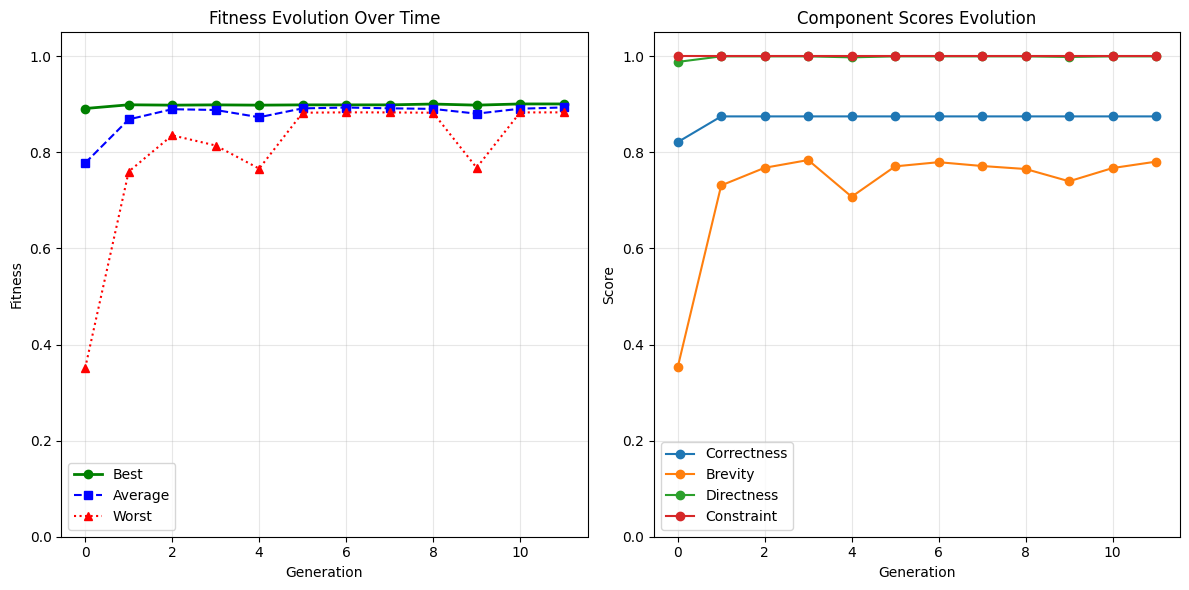

/var/folders/t8/8_h5td5j64sbv55gyxclbfk80000gn/T/ipykernel_70213/2481901810.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=gen_nums)


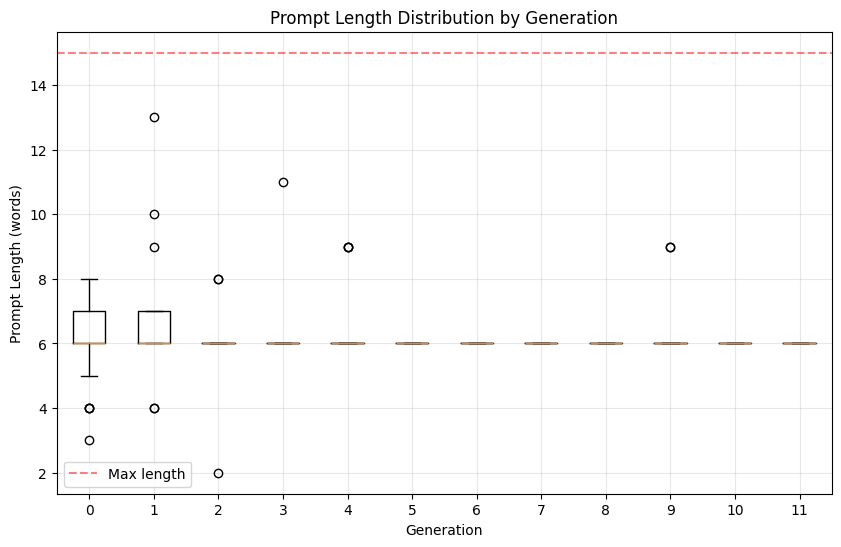


Top 5 Unique Prompts:

1. [Gen 10] Fitness: 0.901 | Length: 6 words
   "Do not include examples or elaboration."
   Scores: correctness: 0.875, brevity: 0.817, directness: 1.000, constraint: 1.000

2. [Gen 0] Fitness: 0.891 | Length: 4 words
   "Answer directly without prefacing."
   Scores: correctness: 0.875, brevity: 0.770, directness: 1.000, constraint: 1.000

3. [Gen 2] Fitness: 0.887 | Length: 8 words
   "Do not include examples or elaboration. Be brief."
   Scores: correctness: 0.875, brevity: 0.808, directness: 1.000, constraint: 1.000

4. [Gen 1] Fitness: 0.885 | Length: 7 words
   "Be brief. Do not add unnecessary details."
   Scores: correctness: 0.875, brevity: 0.737, directness: 1.000, constraint: 1.000

5. [Gen 1] Fitness: 0.884 | Length: 6 words
   "Be brief. Answer directly without prefacing."
   Scores: correctness: 0.875, brevity: 0.733, directness: 1.000, constraint: 1.000


Summary Statistics:
   Initial best: 0.891
   Final best: 0.901
   Improvement: 0.009

Evolu

In [9]:
# Main Execution

if __name__ == "__main__":
    optimizer = EvolutionaryOptimizer(config)
    final_population, stats = optimizer.run()    
    optimizer.save_results(final_population, stats)    
    print("\nGenerating visualizations...")
    visualizer = ResultsVisualizer()
    visualizer.plot_fitness_evolution(
        optimizer.history,
        save_path=f"{config.output_dir}/fitness_evolution.png")
    visualizer.plot_prompt_diversity(
        optimizer.history,
        max_length=config.max_prompt_length,
        save_path=f"{config.output_dir}/prompt_diversity.png")
    visualizer.show_top_prompts(optimizer.history, n=5)    
    print(f"\nSummary Statistics:")
    print(f"   Initial best: {stats['initial_best_fitness']:.3f}")
    print(f"   Final best: {stats['final_best_fitness']:.3f}")
    print(f"   Improvement: {(stats['final_best_fitness'] - stats['initial_best_fitness']):.3f}")
    print(f"\nEvolution completed.")